In [1]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from time import time
from sklearn.inspection import permutation_importance
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier

# Early-Stage Diabetes Risk Prediction

In [16]:
# dataset directory https://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset

diab_src  = '/content/diabetes_data_upload.csv'

In [17]:
diab_df = pd.read_csv(diab_src)
display(diab_df)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [18]:
for i in diab_df.drop(columns=['Age','Gender','class']).columns:
  for idx, val in diab_df[i].items():
    if val == 'Yes':
      diab_df.loc[idx, i] = 1
    else:
      diab_df.loc[idx, i] = 0

In [19]:
for idx, val in diab_df['Gender'].items():
    if val == 'Male':
        diab_df.loc[idx, 'Gender'] = 1
    else:
        diab_df.loc[idx, 'Gender'] = 0

In [20]:
label_encoder = LabelEncoder()
diab_df['class'] = label_encoder.fit_transform(diab_df['class'])

In [21]:
scaler = StandardScaler()
diab_df['Age'] = scaler.fit_transform(diab_df[['Age']])

In [22]:
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# columns_to_encode = diab_df.drop(columns=['Age','class','Gender']).columns.tolist()
# encoded_data = encoder.fit_transform(diab_df[columns_to_encode])
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode), index=diab_df.index)
# diab_df_numerical_parts = diab_df.drop(columns=columns_to_encode)
# diab_df = pd.concat([diab_df_numerical_parts, encoded_df], axis=1)

In [23]:
display(diab_df)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,-0.661367,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,0.821362,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,-0.578993,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,-0.249498,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,0.986110,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,-0.743741,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,-0.002376,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,0.821362,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,-1.320358,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


In [24]:
X = diab_df.drop(columns=['class'])
y = diab_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## MLP

In [25]:
def create_model(trial):
  activation = trial.suggest_categorical('activation', ['identity','logistic','tanh','relu'])
  solver = trial.suggest_categorical('solver', ['lbfgs','sgd','adam'])
  alpha = trial.suggest_float('alpha', 0.0001, 0.1, log=True)
  learning_rate = trial.suggest_categorical('learning_rate', ['constant','invscaling','adaptive'])
  model = MLPClassifier(activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [26]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=10)
  return np.mean(scores)

In [27]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:14:00,796] A new study created in memory with name: no-name-0825e953-1357-4ceb-a219-92be2003724c
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-12-25 09:14:02,428] Trial 0 finished with value: 0.5219512195121951 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.04957910905535945, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.5219512195121951.
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optim



Best parameters:  {'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0008375743877400672, 'learning_rate': 'adaptive'}


MLPClassifier(activation='logistic', alpha=0.0008375743877400672,
              learning_rate='adaptive', solver='lbfgs')

Best cross-validation score: 0.95900
Accuracy on test data: 0.96154
F1 score on test data: 0.96825
Runtime: 310.3317 sec


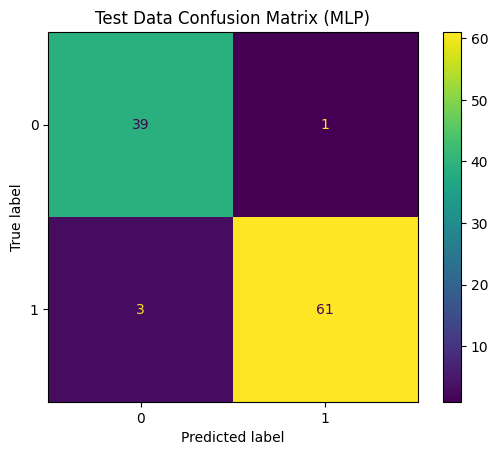

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.98      0.95      0.97        64

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104



In [28]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (MLP)')
plt.show()

print(classification_report(y_test, y_pred))

## XGBoost

In [29]:
def create_model(trial):
  loss = trial.suggest_categorical('loss', ['exponential','log_loss'])
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1, log=True)
  n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
  criterion = trial.suggest_categorical('criterion', ['friedman_mse','squared_error'])
  model = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, criterion=criterion)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [30]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=10)
  return np.mean(scores)

In [31]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:19:11,359] A new study created in memory with name: no-name-c01c7ef9-ea24-4c4e-b816-9eb71c84b4b3
[I 2025-12-25 09:19:14,174] Trial 0 finished with value: 0.9085946573751453 and parameters: {'loss': 'log_loss', 'learning_rate': 0.003934208661975578, 'n_estimators': 200, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.9085946573751453.
[I 2025-12-25 09:19:16,994] Trial 1 finished with value: 0.9038327526132406 and parameters: {'loss': 'log_loss', 'learning_rate': 0.003416575526616138, 'n_estimators': 200, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.9085946573751453.
[I 2025-12-25 09:19:26,210] Trial 2 finished with value: 0.9278164924506388 and parameters: {'loss': 'exponential', 'learning_rate': 0.003931841743499352, 'n_estimators': 600, 'criterion': 'squared_error'}. Best is trial 2 with value: 0.9278164924506388.
[I 2025-12-25 09:19:41,057] Trial 3 finished with value: 0.6153310104529617 and parameters: {'loss': 'log_loss', 'learning_rate



Best parameters:  {'loss': 'exponential', 'learning_rate': 0.09750854256761997, 'n_estimators': 100, 'criterion': 'friedman_mse'}


GradientBoostingClassifier(learning_rate=0.09750854256761997,
                           loss='exponential')

Best cross-validation score: 0.97602
Accuracy on test data: 0.98077
F1 score on test data: 0.98413
Runtime: 296.9586 sec


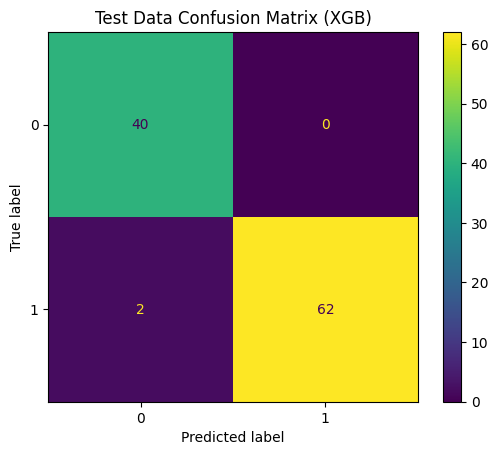

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.97      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



In [32]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (XGB)')
plt.show()

print(classification_report(y_test, y_pred))

## Logistic Regression

In [33]:
def create_model(trial):
  penalty = trial.suggest_categorical('penalty', ['l1','l2','elasticnet',None])
  C = trial.suggest_float('C', 0.0001, 1, log=True)
  model = LogisticRegression(penalty=penalty, C=C)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [34]:
def objective(trial):
  try:
    model = create_model(trial)
    scores = cross_val_score(model, X_train, y_train, cv=10, error_score=0)
    return np.mean(scores)
  except ValueError as e:
    print(f"Warning: Skipping trial {trial.number} due to invalid LogisticRegression parameters: {e}")
    return 0.0

In [35]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:24:08,505] A new study created in memory with name: no-name-ecf1ab72-0b7f-447d-8a50-65a34bb47e0a
[I 2025-12-25 09:24:08,617] Trial 0 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.38499296134325556}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:08,732] Trial 1 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.4037192398694469}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:08,834] Trial 2 finished with value: 0.8845528455284553 and parameters: {'penalty': 'l2', 'C': 0.029144907847805483}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:08,864] Trial 3 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.003803332794838833}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:08,892] Trial 4 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.02534888768410315}. Best is trial 0 with value: 0.92305458768873

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2025-12-25 09:24:09,152] Trial 8 finished with value: 0.9207317073170733 and parameters: {'penalty': None, 'C': 0.029239727854224018}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:09,180] Trial 9 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.2982266898972454}. Be

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

[I 2025-12-25 09:24:09,400] Trial 11 finished with value: 0.9110917537746805 and parameters: {'penalty': 'l2', 'C': 0.13237367456646787}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:09,502] Trial 12 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.6615682226310403}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:09,605] Trial 13 finished with value: 0.9110917537746805 and parameters: {'penalty': 'l2', 'C': 0.12447692349591338}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:09,637] Trial 14 finished with value: 0.0 and parameters: {'penalty': 'elasticnet', 'C': 0.0040078552268879}. Best is trial 0 with value: 0.923054587688734.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Sett

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

[I 2025-12-25 09:24:09,858] Trial 16 finished with value: 0.7763066202090593 and parameters: {'penalty': 'l2', 'C': 0.006355852683901561}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:09,963] Trial 17 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.4164986675518046}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:10,062] Trial 18 finished with value: 0.6153310104529617 and parameters: {'penalty': 'l2', 'C': 0.00011478102408576364}. Best is trial 0 with value: 0.923054587688734.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Sett

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

[I 2025-12-25 09:24:10,491] Trial 22 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.4088073586212142}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:10,598] Trial 23 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.8447997208507599}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:10,700] Trial 24 finished with value: 0.9134727061556329 and parameters: {'penalty': 'l2', 'C': 0.2765852350331251}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:10,803] Trial 25 finished with value: 0.8918118466898954 and parameters: {'penalty': 'l2', 'C': 0.06709836891383035}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:10,904] Trial 26 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.500094396435784}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:11,006] Trial 27 finished with value: 0.9110917537746805 and pa

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

[I 2025-12-25 09:24:11,584] Trial 32 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.5530577349123393}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:11,747] Trial 33 finished with value: 0.9110917537746805 and parameters: {'penalty': 'l2', 'C': 0.11301217161037241}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:12,035] Trial 34 finished with value: 0.923054587688734 and parameters: {'penalty': 'l2', 'C': 0.6379854583070965}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:12,306] Trial 35 finished with value: 0.8435540069686411 and parameters: {'penalty': 'l2', 'C': 0.013364766806943148}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:12,370] Trial 36 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.22521370911373637}. Best is trial 0 with value: 0.923054587688734.


All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

[I 2025-12-25 09:24:12,780] Trial 37 finished with value: 0.9134727061556329 and parameters: {'penalty': 'l2', 'C': 0.35425268313068814}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:12,853] Trial 38 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.0010940376029316883}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:12,903] Trial 39 finished with value: 0.0 and parameters: {'penalty': 'elasticnet', 'C': 0.05404711453153957}. Best is trial 0 with value: 0.923054587688734.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will 

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2025-12-25 09:24:13,167] Trial 40 finished with value: 0.9207317073170733 and parameters: {'penalty': None, 'C': 0.1890506763934876}

All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

[I 2025-12-25 09:24:14,994] Trial 48 finished with value: 0.9134727061556329 and parameters: {'penalty': 'l2', 'C': 0.28926809565802514}. Best is trial 0 with value: 0.923054587688734.
[I 2025-12-25 09:24:15,032] Trial 49 finished with value: 0.0 and parameters: {'penalty': 'elasticnet', 'C': 0.019434659784620435}. Best is trial 0 with value: 0.923054587688734.


All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_log

LogisticRegression(C=0.38499296134325556)

Best cross-validation score: 0.92305
Accuracy on test data: 0.94231
F1 score on test data: 0.95161
Runtime: 6.6838 sec


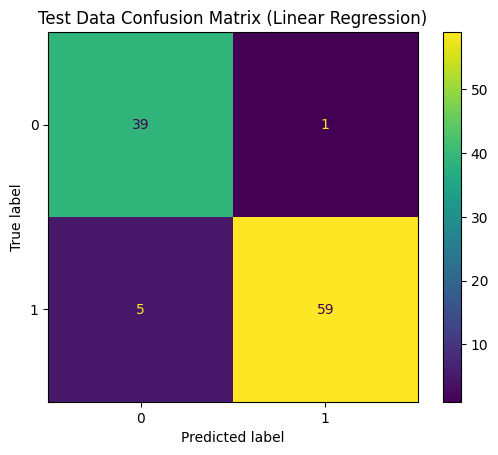

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        40
           1       0.98      0.92      0.95        64

    accuracy                           0.94       104
   macro avg       0.93      0.95      0.94       104
weighted avg       0.95      0.94      0.94       104



In [36]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (Linear Regression)')
plt.show()

print(classification_report(y_test, y_pred))

## Naive Bayes

In [37]:
def create_model(trial):
  # Only GaussianNB is compatible with the current scaled data which can have negative values.
  # ComplementNB and CategoricalNB require non-negative features.
  NB_type = trial.suggest_categorical('NB_type', ['gaussian'])

  if NB_type == 'gaussian':
    var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1, log=True)
    model = GaussianNB(var_smoothing=var_smoothing)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [38]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=10)
  return np.mean(scores)

In [39]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:24:15,404] A new study created in memory with name: no-name-eccad08e-db36-4596-a5ef-03499bfe0bef
[I 2025-12-25 09:24:15,466] Trial 0 finished with value: 0.8747967479674796 and parameters: {'NB_type': 'gaussian', 'var_smoothing': 0.00011325996569428048}. Best is trial 0 with value: 0.8747967479674796.
[I 2025-12-25 09:24:15,521] Trial 1 finished with value: 0.8747967479674796 and parameters: {'NB_type': 'gaussian', 'var_smoothing': 2.0655321289169076e-08}. Best is trial 0 with value: 0.8747967479674796.
[I 2025-12-25 09:24:15,591] Trial 2 finished with value: 0.8747967479674796 and parameters: {'NB_type': 'gaussian', 'var_smoothing': 1.0735653346097346e-10}. Best is trial 0 with value: 0.8747967479674796.
[I 2025-12-25 09:24:15,646] Trial 3 finished with value: 0.8747967479674796 and parameters: {'NB_type': 'gaussian', 'var_smoothing': 9.243587109243703e-09}. Best is trial 0 with value: 0.8747967479674796.
[I 2025-12-25 09:24:15,706] Trial 4 finished with value: 0.8747



Best parameters:  {'NB_type': 'gaussian', 'var_smoothing': 0.005756349469955714}


GaussianNB(var_smoothing=0.005756349469955714)

Best cross-validation score: 0.87967
Accuracy on test data: 0.94231
F1 score on test data: 0.95238
Runtime: 3.0153 sec


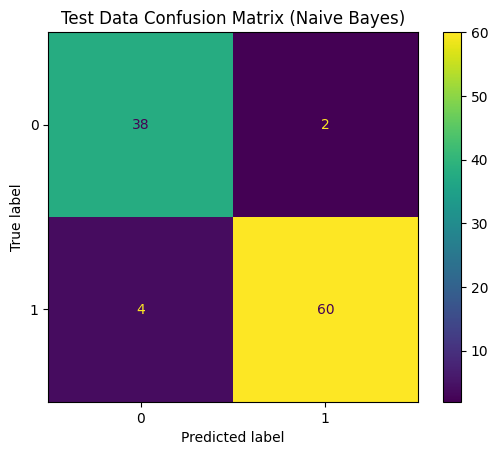

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.97      0.94      0.95        64

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104



In [40]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (Naive Bayes)')
plt.show()

print(classification_report(y_test, y_pred))

## SVM

In [41]:
def create_model(trial):
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

  if kernel == 'linear':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    model = SVC(kernel=kernel, C=C)
  elif kernel == 'poly':
    C = trial.suggest_float('C', 0.01, 100, log=True)
    degree = trial.suggest_int('degree', 3, 10, step=1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = SVC(kernel=kernel, C=C, degree=degree, gamma=gamma)
  elif kernel == 'rbf':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = SVC(kernel=kernel, C=C, gamma=gamma)
  elif kernel == 'sigmoid':
    C = trial.suggest_float('C', 0.001, 1000, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    model = SVC(kernel=kernel, C=C, gamma=gamma)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [42]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=10)
  return np.mean(scores)

In [43]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:24:18,597] A new study created in memory with name: no-name-c7e02b9c-580c-4576-8bd1-3edadffba546
[I 2025-12-25 09:24:18,702] Trial 0 finished with value: 0.9256678281068526 and parameters: {'kernel': 'poly', 'C': 17.91282959200003, 'degree': 8, 'gamma': 'scale'}. Best is trial 0 with value: 0.9256678281068526.
[I 2025-12-25 09:24:18,801] Trial 1 finished with value: 0.7762485481997676 and parameters: {'kernel': 'sigmoid', 'C': 1.820057637203681, 'gamma': 'scale'}. Best is trial 0 with value: 0.9256678281068526.
[I 2025-12-25 09:24:19,456] Trial 2 finished with value: 0.9326364692218352 and parameters: {'kernel': 'linear', 'C': 91.8396877159719}. Best is trial 2 with value: 0.9326364692218352.
[I 2025-12-25 09:24:19,631] Trial 3 finished with value: 0.9326364692218352 and parameters: {'kernel': 'linear', 'C': 14.731543774719743}. Best is trial 2 with value: 0.9326364692218352.
[I 2025-12-25 09:24:19,742] Trial 4 finished with value: 0.7426829268292683 and parameters: {'



Best parameters:  {'kernel': 'rbf', 'C': 28.874923773345376, 'gamma': 'auto'}


SVC(C=28.874923773345376, gamma='auto')

Best cross-validation score: 0.96876
Accuracy on test data: 0.97115
F1 score on test data: 0.97638
Runtime: 5.7563 sec


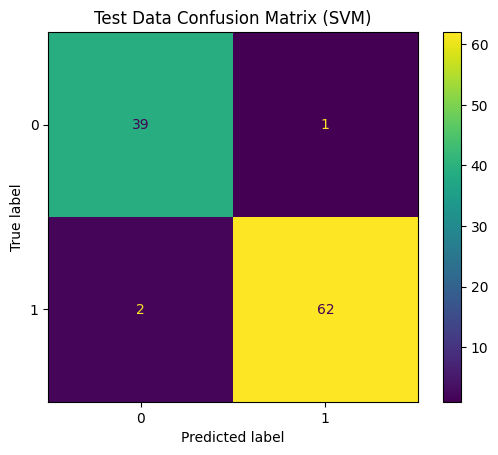

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        40
           1       0.98      0.97      0.98        64

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104



In [44]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (SVM)')
plt.show()

print(classification_report(y_test, y_pred))

## KNN

In [45]:
def create_model(trial):
  n_neighbors = trial.suggest_int('n_neighbors', 1, 20, step=5)
  weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
  algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
  model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [46]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=10)
  return np.mean(scores)

In [47]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:24:24,518] A new study created in memory with name: no-name-ef8acd84-09d9-4b56-a488-793f84bdd6bb
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [1, 20] and step=5, but the range is not divisible by `step`. It will be replaced with [1, 16].
  warnings.warn(
[I 2025-12-25 09:24:24,584] Trial 0 finished with value: 0.9616144018583043 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 0 with value: 0.9616144018583043.
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [1, 20] and step=5, but the range is not divisible by `step`. It will be replaced with [1, 16].
  warnings.warn(
[I 2025-12-25 09:24:24,643] Trial 1 finished with value: 0.9616144018583043 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 0 with value: 0.9616144018583043.
/usr/local/lib/pyth



Best parameters:  {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute'}


/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [1, 20] and step=5, but the range is not divisible by `step`. It will be replaced with [1, 16].
  warnings.warn(


KNeighborsClassifier(algorithm='brute', n_neighbors=1, weights='distance')

Best cross-validation score: 0.96870
Accuracy on test data: 0.95192
F1 score on test data: 0.96000
Runtime: 4.4189 sec


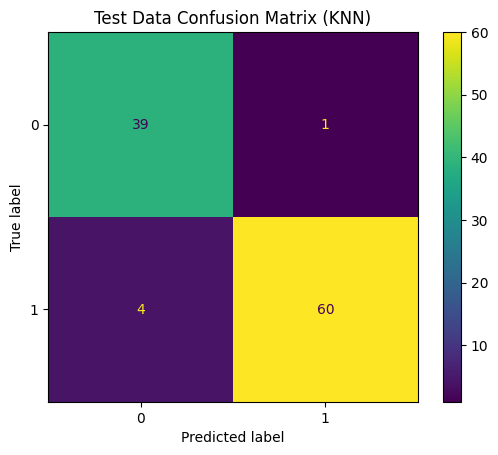

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        40
           1       0.98      0.94      0.96        64

    accuracy                           0.95       104
   macro avg       0.95      0.96      0.95       104
weighted avg       0.95      0.95      0.95       104



In [48]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (KNN)')
plt.show()

print(classification_report(y_test, y_pred))

## Random Forest

In [49]:
def create_model(trial):
  criterion = trial.suggest_categorical('criterion', ['gini','entropy','log_loss'])
  max_features = trial.suggest_categorical('max_features', ['sqrt','log2',None])
  n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
  verbose = trial.suggest_int('verbose', 0, 5, step=1)
  model = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators)

  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return model

In [50]:
def objective(trial):
  model = create_model(trial)
  scores = cross_val_score(model, X_train, y_train, cv=10)
  return np.mean(scores)

In [51]:
start = time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)

best_model = create_model(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-12-25 09:24:29,110] A new study created in memory with name: no-name-415e6c2f-84a3-4480-8920-2c59255ea107
[I 2025-12-25 09:24:30,825] Trial 0 finished with value: 0.9783972125435539 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'verbose': 0}. Best is trial 0 with value: 0.9783972125435539.
[I 2025-12-25 09:24:34,533] Trial 1 finished with value: 0.9641114982578397 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 200, 'verbose': 3}. Best is trial 0 with value: 0.9783972125435539.
[I 2025-12-25 09:24:48,612] Trial 2 finished with value: 0.9760162601626016 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 800, 'verbose': 5}. Best is trial 0 with value: 0.9783972125435539.
[I 2025-12-25 09:25:02,728] Trial 3 finished with value: 0.9807781649245063 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 800, 'verbose': 2}. Best is trial 3 with value: 0.9807781649



Best parameters:  {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 800, 'verbose': 2}


RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=800)

Best cross-validation score: 0.97602
Accuracy on test data: 0.99038
F1 score on test data: 0.99213
Runtime: 423.4283 sec


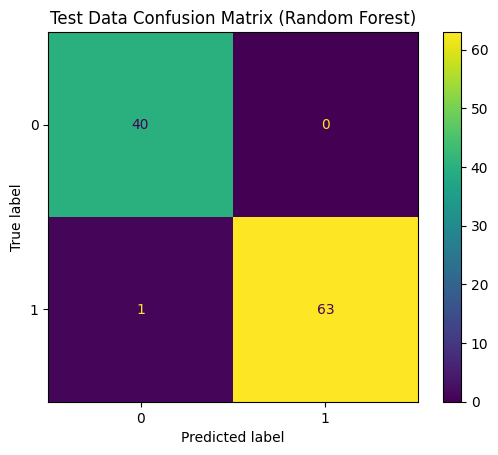

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.98      0.99        64

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



In [52]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Best cross-validation score: %.5f" % np.mean(scores))
y_pred = best_model.predict(X_test)
print("Accuracy on test data: %.5f" % accuracy_score(y_test,y_pred))
print("F1 score on test data: %.5f" % f1_score(y_test,y_pred))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

all_labels = np.sort(np.unique(y_test))

cfm = confusion_matrix(y_test, y_pred, labels=all_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm,
                                    display_labels = all_labels)
cm_display.plot()
plt.title('Test Data Confusion Matrix (Random Forest)')
plt.show()

print(classification_report(y_test, y_pred))

## Feature Importance

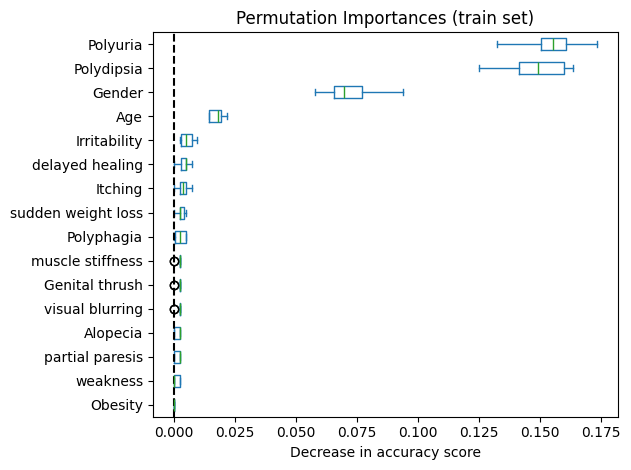

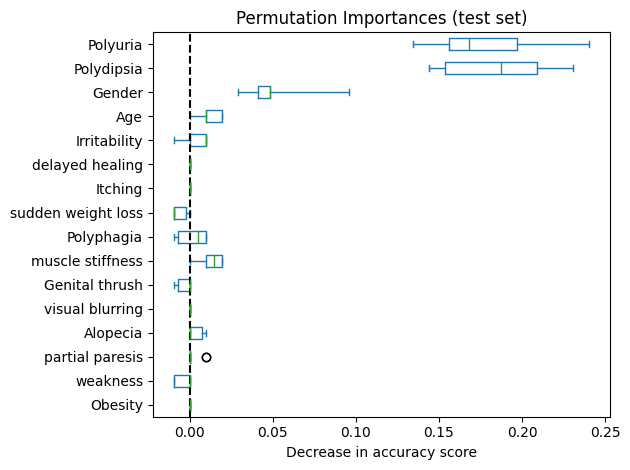

In [66]:
train_result = permutation_importance(best_model, X_train, y_train, n_repeats=10, random_state=42)
test_results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_importances_idx = train_result.importances_mean.argsort()
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

Upon inspecting the influence of each feature in the Random Forest model using Permuation Feature Importance (PFI), the top 3 features with the most decrease in accuracy score are Polyuria, Polydispia, and Gender both in the train and test set PFI. This means that upon random shuffling of values in each feature, these 3 features exhibited the most variation in model performance, thus are also the most important factors in early-stage diabetes risk prediction.